## LLM: HW2
### Zeinab Sheikhitarghi

In [ ]:
!pip install transformers datasets

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BertTokenizer
from typing import List, Tuple, Dict
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

# 3.1 Data preprocessing

In [ ]:
class DataLoaderWrapper:
    """
        A wrapper class for loading and preprocessing the IMDB dataset for word context modeling.
        This class handles the loading of the dataset, tokenization, and extraction of word-context pairs
        for training a Word2Vec model. It prepares the data in a format suitable for training with specified
        parameters such as the number of samples and the context window radius.
    """

    def __init__(self, dataset_name="scikit-learn/imdb", tokenizer_name="bert-base-uncased", max_length=256, n_samples=5000, batch_size=32, radius=5, K=10):
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name, do_lower_case=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dataset = load_dataset(dataset_name, split="train")
        self.max_length = max_length
        self.n_samples = n_samples
        self.batch_size = batch_size
        self.radius = radius
        self.K = K
        self.train_loader, self.valid_loader = self.prepare_data()

    def preprocessing_fn(self, x):
        """ Tokenizes the input text and converts sentiment labels."""
        x["review_ids"] = self.tokenizer(
                x["review"],
                add_special_tokens=False,
                truncation=True,
                max_length=self.max_length,
                padding=False,
                return_attention_mask=False,
            )["input_ids"]
        x["label"] = 0 if x["sentiment"] == "negative" else 1
        return x

    def extract_words_contexts(self, text, radius):
        """
            Extracts words and their surrounding contexts based on the specified radius.
        """
        window_size = 2 * radius
        context_ids = []

        for i, _ in enumerate(text):
            pos_context_ids = []
            start = i - radius
            end = i + radius + 1

            for j in range(start, end):
                if j < 0:
                    pos_context_ids.append(0)  # pad the left of the sequence
                    continue

                if j >= len(text):
                    pos_context_ids.append(0)  # pad the left of the sequence
                    continue

                elif i != j:
                    pos_context_ids.append(text[j])

            if len(pos_context_ids) == window_size:
                context_ids.append(pos_context_ids)

        return text, context_ids

    def flatten_dataset_to_list(self, ds):
        """
            Flattens the dataset to a list of words and their corresponding contexts.
        """
        mapped_dataset = ds.map(
              lambda doc: {
                  "words": (result := self.extract_words_contexts(doc["review_ids"], self.radius))[0],
                  "contexts": result[1],
              },
              remove_columns=["review_ids"],
          )

        all_words = sum(mapped_dataset["words"], [])
        all_contexts = sum(mapped_dataset["contexts"], [])
        print("DataSet Flattened\n")
        return all_words, all_contexts

    def prepare_data(self):
        """
            Prepares the training and validation data loaders.
            This method shuffles the dataset, selects a subset of samples, tokenizes the data, and splits it
            into training and validation sets.
        """
        columns_to_remove = self.dataset.column_names
        shuffled_dataset = self.dataset.shuffle(seed=42)
        selected_dataset = shuffled_dataset.select(range(self.n_samples))
        tokenized_dataset = selected_dataset.map(lambda x: self.preprocessing_fn(x))
        tokenized_dataset = tokenized_dataset.remove_columns(column_names=columns_to_remove)
        dataset_split = tokenized_dataset.train_test_split(test_size=0.2)

        train_words, train_contexts = self.flatten_dataset_to_list(ds=dataset_split['train'])
        valid_words, valid_contexts = self.flatten_dataset_to_list(ds=dataset_split['test'])

        train_set = IMDBWordContextDataset(words=train_words, contexts=train_contexts)
        valid_set = IMDBWordContextDataset(words=valid_words, contexts=valid_contexts)

        train_loader = DataLoader(
          train_set, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn
        )
        valid_loader = DataLoader(
          valid_set, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn
        )

        return train_loader, valid_loader

    def collate_fn(self, batch):
        word_ids, pos_context_ids = zip(*batch)
        neg_context_ids = torch.randint(0, self.tokenizer.vocab_size, (len(batch), 2 * self.K * self.radius), dtype=torch.long)
        return {
              "word_id": torch.tensor(word_ids, dtype=torch.long).to(self.device),
              "positive_context_ids": torch.stack([torch.tensor(ctx, dtype=torch.long) for ctx in pos_context_ids]).to(self.device),
              "negative_context_ids": neg_context_ids.to(self.device),
        }


In [ ]:
class IMDBWordContextDataset(torch.utils.data.Dataset):

    def __init__(self, words, contexts):
        self.words = words
        self.contexts = contexts

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx: int):
        return self.words[idx], self.contexts[idx]

# 3.2 Define the Word2Vec Model

In [ ]:
class Word2Vec(nn.Module):
    """
        This model utilizes two separate embedding layers: one for the target words and another for the
        context words. The forward method computes the similarity scores between the target words and their corresponding positive and
        negative context words.

    """

    def __init__(self, vocab_size, embedding_dim, padding_idx=0):
        super(Word2Vec, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)

    def forward(self, word_ids, positive_context_ids, negative_context_ids):
        w = self.word_embeddings(word_ids)  # shape: (batch_size, embedding_dim)
        C_plus = self.context_embeddings(positive_context_ids)  # shape: (batch_size, 2R, embedding_dim)
        C_minus = self.context_embeddings(negative_context_ids)  # shape: (batch_size, 2KR, embedding_dim)

        pos_similarity_scores = torch.sigmoid((C_plus * w.unsqueeze(1)).sum(dim=2))  # shape: (batch_size, 2R)
        neg_similarity_scores = torch.sigmoid(-(C_minus * w.unsqueeze(1)).sum(dim=2))  # shape: (batch_size, 2KR)

        return pos_similarity_scores, neg_similarity_scores

    def contrastive_loss(self, pos_scores, neg_scores):
        pos_labels = torch.ones_like(pos_scores)
        neg_labels = torch.zeros_like(neg_scores)

        pos_loss = -torch.mean(pos_labels * torch.log(pos_scores + 1e-9)) # Add epsilon for numerical stability
        neg_loss = -torch.mean(neg_labels * torch.log(1 - neg_scores + 1e-9))
        return pos_loss + neg_loss

In [ ]:
class Trainer:
    """
        A class for training and validating a machine learning model.
        This class handles the training and evaluation processes of a model using
        contrastive learning. It supports both training and validation phases and
        includes methods for plotting loss curves and saving the trained model.

    """

    def __init__(self, model, train_loader, valid_loader, device, lr=0.025, n_epochs=10):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.lr = lr
        self.n_epochs = n_epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
        self.train_loss = []
        self.val_acc = 0
        self.val_loss = 0

    def train(self):
        self.model.train()
        for epoch in range(self.n_epochs):
            total_loss = 0
            for batch in self.train_loader:
                self.optimizer.zero_grad()
                word_ids = batch["word_id"].to(self.device)
                pos_context_ids = batch["positive_context_ids"].to(self.device)
                neg_context_ids = batch["negative_context_ids"].to(self.device)

                pos_scores, neg_scores = self.model(word_ids, pos_context_ids, neg_context_ids)
                loss = self.model.contrastive_loss(pos_scores, neg_scores)
                total_loss += loss.item()
                loss.backward()
                self.optimizer.step()

            self.scheduler.step()
            avg_loss = total_loss / len(self.train_loader)
            self.train_loss.append(avg_loss)
            print(f"Epoch {epoch + 1}/{self.n_epochs}, Loss: {avg_loss:.4f}\n")

    def validate(self):

        self.model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for batch in self.valid_loader:
                word_ids = batch["word_id"].to(self.device)
                pos_context_ids = batch["positive_context_ids"].to(self.device)
                neg_context_ids = batch["negative_context_ids"].to(self.device)

                pos_scores, neg_scores = self.model(word_ids, pos_context_ids, neg_context_ids)
                loss = self.model.contrastive_loss(pos_scores, neg_scores)
                total_loss += loss.item()

                total_samples += pos_scores.numel() + neg_scores.numel()
                pos_predictions = (pos_scores > 0.5).float()
                neg_predictions = (neg_scores <= 0.5).float()
                total_correct += (pos_predictions.sum() + neg_predictions.sum()).item()

        average_loss = total_loss / len(self.valid_loader)
        accuracy = total_correct / total_samples
        self.val_acc = accuracy
        self.val_loss = average_loss

        print(f"Validation Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.4f}\n")

    def plot_loss_curve(self):
        plt.plot(self.train_loss, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.show()

In [ ]:
def save_model(
    model,
    embedding_size: int,
    radius: int,
    sampling_ratio: int,
    batch_size: int,
    n_epoch: int,
    base_dir: str):

    current_dir = os.getcwd()
    full_base_dir = os.path.join(current_dir, base_dir)
    if not os.path.exists(full_base_dir):
        os.makedirs(full_base_dir)

    file_name = f"model_dim-{embedding_size}_radius{radius}_ratio-{sampling_ratio}-batch-{batch_size}-epoch-{n_epoch}.ckpt"
    save_path = os.path.join(base_dir, file_name)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved at {save_path}\n")

# Intrinsic Evaluation of the Embeddings

In [ ]:
class WordEmbeddingEvaluator:
    def __init__(self, embeddings, vocab, tokenizer):
        self.embeddings = embeddings
        self.vocab = vocab
        self.tokenizer = tokenizer

    def get_word_embedding(self, word):
        """Retrieves the embedding for a given word."""
        word_id = self.vocab.get(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            print(f"Word '{word}' not in vocabulary.")
            return None

    def evaluate_similarity(self, words):
        """Evaluates the cosine similarity between pairs of words."""
        similarities = {}
        word_embeddings = [self.get_word_embedding(word) for word in words]

        for i, word1 in enumerate(words):
            for j, word2 in enumerate(words):
                if i < j and word_embeddings[i] is not None and word_embeddings[j] is not None:
                    similarity = F.cosine_similarity(word_embeddings[i].unsqueeze(0), word_embeddings[j].unsqueeze(0)).item()
                    similarities[(word1, word2)] = f"{similarity:.4f}"
        return similarities

    def analogy(self, word1, word2, word3, top_k=5):
        """Finds words that complete the analogy."""
        if word1 in self.vocab and word2 in self.vocab and word3 in self.vocab:
            vec1 = self.get_word_embedding(word1)
            vec2 = self.get_word_embedding(word2)
            vec3 = self.get_word_embedding(word3)
            target_vector = vec2 - vec1 + vec3

            # Normalize target vector
            target_vector = target_vector / target_vector.norm()
            similarities = torch.matmul(self.embeddings, target_vector.unsqueeze(0).T)
            most_similar_indices = torch.topk(similarities.flatten(), top_k).indices

            results = [
            self.tokenizer.convert_ids_to_tokens(idx.item())
            for idx in most_similar_indices
            if idx.item() < self.tokenizer.vocab_size and
            self.tokenizer.convert_ids_to_tokens(idx.item()) not in {word1, word2, word3}
            ]

        else:
            print("One or more words not in vocabulary.")
            return None

    def nearest_neighbors(self, word, top_k=10):
        if word in vocab:
            word_id = self.tokenizer.encode(word, add_special_tokens=False)[0]
            word_vec = self.embeddings[self.vocab[word]]
            similarities = torch.matmul(self.embeddings, word_vec)

            nearest_indices = torch.topk(similarities, top_k + 1).indices[1:]  # Skip the first index (the word itself)

            nearest_indices = [idx for idx in nearest_indices if idx.item() != word_id]

            return [tokenizer.convert_ids_to_tokens(idx.item()) for idx in nearest_indices[:top_k]]
        else:
            print(f"Word '{word}' not found in vocabulary.")
            return None


    def extract_adjective_embeddings(self, adjectives):
        """Extracts embeddings for a list of adjectives."""
        embeddings = []
        labels = []
        for adj in adjectives:
            if adj in self.vocab:
                embeddings.append(self.get_word_embedding(adj).detach().cpu().numpy())
                labels.append(adj)
        return np.array(embeddings), labels

    def visualize_embeddings(self, word_groups, colors, labels, perplexity=5.0):
        """Visualizes embeddings using t-SNE for multiple groups of words and annotates the words."""
        all_embeddings = []
        all_labels = []
        all_words = []  # Store words for annotations

        for group, color, label in zip(word_groups, colors, labels):
            embeddings = []
            for word in group:
                if word in self.vocab:
                    # Ensure we're moving to CPU before converting to numpy
                    embeddings.append(self.get_word_embedding(word).detach().cpu().numpy())

            if embeddings:  # Only proceed if there are embeddings
                all_embeddings.append(np.array(embeddings))
                all_labels.append(label)
                all_words.append(group)  # Store the words

        # Concatenate all embeddings for t-SNE
        if all_embeddings:
            combined_embeddings = np.concatenate(all_embeddings, axis=0)
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
            embeddings_2d = tsne.fit_transform(combined_embeddings)

            plt.figure(figsize=(10, 8))

            start_idx = 0
            for idx, (embeddings, color, label, words) in enumerate(zip(all_embeddings, colors, all_labels, all_words)):
                end_idx = start_idx + embeddings.shape[0]
                plt.scatter(embeddings_2d[start_idx:end_idx, 0],
                            embeddings_2d[start_idx:end_idx, 1],
                            marker='o', color=color, label=label)
                # Annotate each point with the corresponding word
                for i in range(start_idx, end_idx):
                    plt.annotate(words[i - start_idx],
                                 (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                                 fontsize=9, alpha=0.7)

                start_idx = end_idx

            plt.title("2D Visualization of Word Embeddings")
            plt.xlabel("t-SNE Component 1")
            plt.ylabel("t-SNE Component 2")
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print("No embeddings found for visualization.")

# Ablation Study

## First set of Hyperparameters:

Radius = 5

Negative Sampling Factor = 10

Embedding Dimention = 100

Batch Size = 16

Number of Epochs = 5

In [ ]:
K = 10
R = 5
d = 100
B = 16
E = 5

In [ ]:
data_loader_wrapper = DataLoaderWrapper(n_samples=5000, batch_size=B, radius=R, K=K)
train_loader = data_loader_wrapper.train_loader
valid_loader = data_loader_wrapper.valid_loader

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DataSet Flattened




Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DataSet Flattened




In [ ]:
for i, batch in enumerate(train_loader):

    if i >= 3:
        break

    print(f"Shapes of tensors in batch {i + 1}:")

    print(f"word_id: {batch['word_id'].size()}")

    print(f"positive_context_ids: {batch['positive_context_ids'].shape}")

    print(f"negative_context_ids: {batch['negative_context_ids'].shape}\n")

Shapes of tensors in batch 1:

word_id: torch.Size([16])

positive_context_ids: torch.Size([16, 10])

negative_context_ids: torch.Size([16, 100])



Shapes of tensors in batch 2:

word_id: torch.Size([16])

positive_context_ids: torch.Size([16, 10])

negative_context_ids: torch.Size([16, 100])



Shapes of tensors in batch 3:

word_id: torch.Size([16])

positive_context_ids: torch.Size([16, 10])

negative_context_ids: torch.Size([16, 100])




In [ ]:
model1 = Word2Vec(vocab_size=data_loader_wrapper.tokenizer.vocab_size, embedding_dim=d).to(data_loader_wrapper.device)

Epoch 1/5, Loss: 0.1480



Epoch 2/5, Loss: 0.0109



Epoch 3/5, Loss: 0.0102



Epoch 4/5, Loss: 0.0101



Epoch 5/5, Loss: 0.0101



Validation Loss: 0.0886, Validation Accuracy: 0.8233




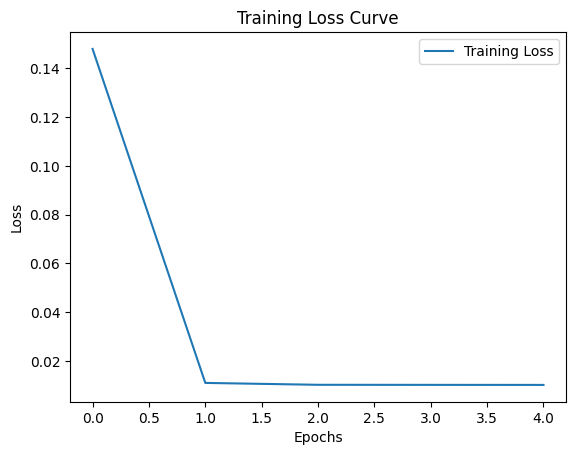

In [ ]:
trainer = Trainer(model1, train_loader, valid_loader, data_loader_wrapper.device, n_epochs=E)
trainer.train()
trainer.validate()
trainer.plot_loss_curve()

In [ ]:
save_model(model1, d, R, K, B, E, base_dir='word2vec')

Model saved at /content/word2vec/model_dim-100_radius5_ratio-10-batch-16-epoch-5.ckpt




## Second set of Hyperparameters: (increasing the size of the embedding from 100 to 300)

Radius = 5

Negative Sampling Factor = 10

Embedding Dimention = 300

Batch Size = 16

Number of Epochs = 5

In [ ]:
K = 10
R = 5
d = 300
B = 16
E = 5

In [ ]:
data_loader_wrapper = DataLoaderWrapper(n_samples=5000, batch_size=B, radius=R, K=K)
train_loader = data_loader_wrapper.train_loader
valid_loader = data_loader_wrapper.valid_loader

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DataSet Flattened



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DataSet Flattened



In [ ]:
for i, batch in enumerate(train_loader):

    if i >= 3:
        break

    print(f"Shapes of tensors in batch {i + 1}:")

    print(f"word_id: {batch['word_id'].size()}")

    print(f"positive_context_ids: {batch['positive_context_ids'].shape}")

    print(f"negative_context_ids: {batch['negative_context_ids'].shape}\n")

Shapes of tensors in batch 1:
word_id: torch.Size([16])
positive_context_ids: torch.Size([16, 10])
negative_context_ids: torch.Size([16, 100])

Shapes of tensors in batch 2:
word_id: torch.Size([16])
positive_context_ids: torch.Size([16, 10])
negative_context_ids: torch.Size([16, 100])

Shapes of tensors in batch 3:
word_id: torch.Size([16])
positive_context_ids: torch.Size([16, 10])
negative_context_ids: torch.Size([16, 100])



In [ ]:
model2 = Word2Vec(vocab_size=data_loader_wrapper.tokenizer.vocab_size, embedding_dim=d).to(data_loader_wrapper.device)

Epoch 1/5, Loss: 0.2489

Epoch 2/5, Loss: 0.0137

Epoch 3/5, Loss: 0.0108

Epoch 4/5, Loss: 0.0106

Epoch 5/5, Loss: 0.0106

Validation Loss: 0.1103, Validation Accuracy: 0.8234



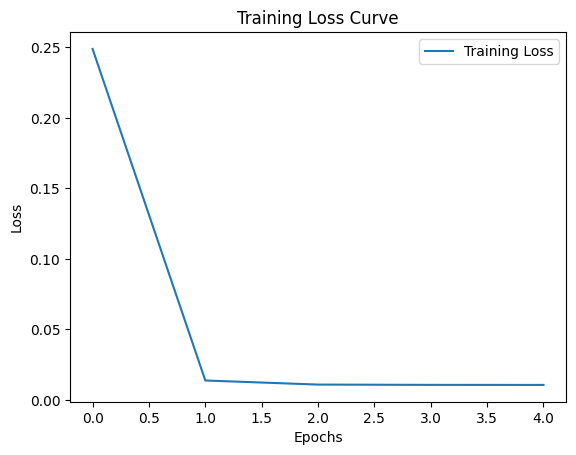

In [ ]:
trainer = Trainer(model2, train_loader, valid_loader, data_loader_wrapper.device, n_epochs=E)
trainer.train()
trainer.validate()
trainer.plot_loss_curve()

In [ ]:
save_model(model2, d, R, K, B, E, base_dir='word2vec')

Model saved at word2vec/model_dim-300_radius5_ratio-10-batch-16-epoch-5.ckpt



## Third set of hyperparameters(Reducing the size of radius and negative sampling factor)

K = 5

R = 3

B = 16

E = 5

d = 100

In [ ]:
K = 5
R = 3
d = 100
B = 16
E = 5

In [ ]:
data_loader_wrapper = DataLoaderWrapper(n_samples=5000, batch_size=B, radius=R, K=K)
train_loader = data_loader_wrapper.train_loader
valid_loader = data_loader_wrapper.valid_loader

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DataSet Flattened



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DataSet Flattened



In [ ]:
for i, batch in enumerate(train_loader):

    if i >= 3:
        break

    print(f"Shapes of tensors in batch {i + 1}:")

    print(f"word_id: {batch['word_id'].size()}")

    print(f"positive_context_ids: {batch['positive_context_ids'].shape}")

    print(f"negative_context_ids: {batch['negative_context_ids'].shape}\n")

Shapes of tensors in batch 1:
word_id: torch.Size([16])
positive_context_ids: torch.Size([16, 6])
negative_context_ids: torch.Size([16, 30])

Shapes of tensors in batch 2:
word_id: torch.Size([16])
positive_context_ids: torch.Size([16, 6])
negative_context_ids: torch.Size([16, 30])

Shapes of tensors in batch 3:
word_id: torch.Size([16])
positive_context_ids: torch.Size([16, 6])
negative_context_ids: torch.Size([16, 30])



In [ ]:
model3 = Word2Vec(vocab_size=data_loader_wrapper.tokenizer.vocab_size, embedding_dim=d).to(data_loader_wrapper.device)

Epoch 1/5, Loss: 0.1727

Epoch 2/5, Loss: 0.0083

Epoch 3/5, Loss: 0.0068

Epoch 4/5, Loss: 0.0068

Epoch 5/5, Loss: 0.0068

Validation Loss: 0.0868, Validation Accuracy: 0.8391



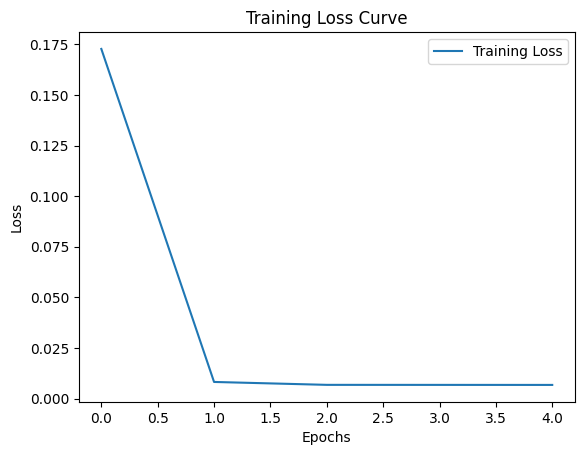

In [ ]:
trainer = Trainer(model3, train_loader, valid_loader, data_loader_wrapper.device, n_epochs=E)
trainer.train()
trainer.validate()
trainer.plot_loss_curve()

In [ ]:
save_model(model3, d, R, K, B, E, base_dir='word2vec')

Model saved at word2vec/model_dim-100_radius3_ratio-5-batch-16-epoch-5.ckpt



## Test best set of hyperparameters on more train data (10,000 samples)

In [ ]:
K = 5
R = 3
d = 100
B = 16
E = 5

In [ ]:
data_loader_wrapper = DataLoaderWrapper(n_samples=10000, batch_size=B, radius=R, K=K)
train_loader = data_loader_wrapper.train_loader
valid_loader = data_loader_wrapper.valid_loader

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

DataSet Flattened



Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DataSet Flattened



In [ ]:
model4 = Word2Vec(vocab_size=data_loader_wrapper.tokenizer.vocab_size, embedding_dim=d).to(data_loader_wrapper.device)

Epoch 1/5, Loss: 0.1046

Epoch 2/5, Loss: 0.0075

Epoch 3/5, Loss: 0.0068

Epoch 4/5, Loss: 0.0068

Epoch 5/5, Loss: 0.0068

Validation Loss: 0.0424, Validation Accuracy: 0.8761



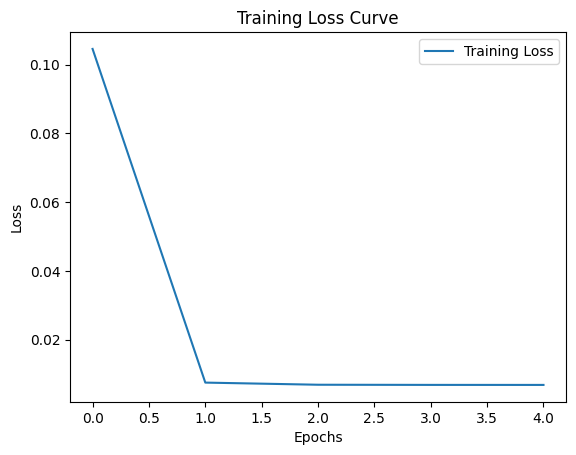

In [ ]:
trainer = Trainer(model4, train_loader, valid_loader, data_loader_wrapper.device, n_epochs=E)
trainer.train()
trainer.validate()
trainer.plot_loss_curve()

In [ ]:
save_model(model4, d, R, K, B, E, base_dir='best_model')

Model saved at best_model/model_dim-100_radius3_ratio-5-batch-16-epoch-5.ckpt



## Test best set of hyperparameters on the whole train dataset

In [ ]:
K = 5
R = 4
d = 100
B = 16
E = 5

In [ ]:
data_loader_wrapper = DataLoaderWrapper(n_samples=50000, batch_size=B, radius=R, K=K)
train_loader = data_loader_wrapper.train_loader
valid_loader = data_loader_wrapper.valid_loader

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

DataSet Flattened



Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

DataSet Flattened



In [ ]:
model5 = Word2Vec(vocab_size=data_loader_wrapper.tokenizer.vocab_size, embedding_dim=d).to(data_loader_wrapper.device)

Epoch 1/5, Loss: 0.0308

Epoch 2/5, Loss: 0.0085

Epoch 3/5, Loss: 0.0084

Epoch 4/5, Loss: 0.0084

Epoch 5/5, Loss: 0.0084

Validation Loss: 0.0113, Validation Accuracy: 0.9282



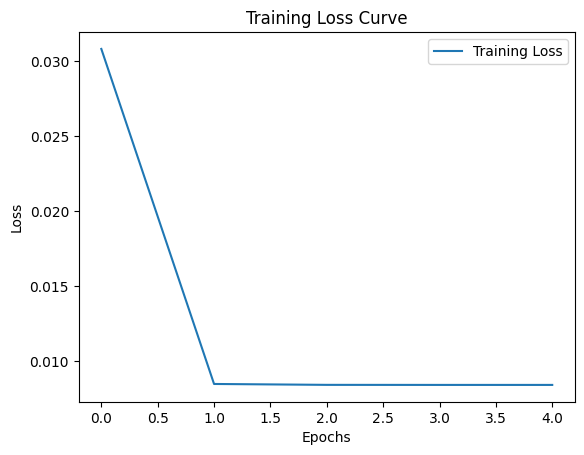

In [ ]:
trainer = Trainer(model5, train_loader, valid_loader, data_loader_wrapper.device, n_epochs=E)
trainer.train()
trainer.validate()
trainer.plot_loss_curve()

In [ ]:
save_model(model5, d, R, K, B, E, base_dir='word2vec')

Model saved at word2vec/model_dim-100_radius4_ratio-5-batch-16-epoch-5.ckpt



## Intrinsic Evaluation on the Best Trained Word2Vec Model

In [ ]:
def load_embedding(file_path: str):
    state_dict = torch.load(file_path)
    return state_dict['word_embeddings.weight']

In [ ]:
embeddings = load_embedding("/kaggle/working/word2vec/model_dim-100_radius4_ratio-5-batch-16-epoch-5.ckpt")
vocab = data_loader_wrapper.tokenizer.vocab
tokenizer = data_loader_wrapper.tokenizer

evaluator = WordEmbeddingEvaluator(embeddings, vocab, tokenizer)

## 1. Word Similarities

In [ ]:
similarities = evaluator.evaluate_similarity(['good', 'better', 'bad', 'worse'])
similarities

{('good', 'better'): '0.5139',
 ('good', 'bad'): '0.6134',
 ('good', 'worse'): '0.5455',
 ('better', 'bad'): '0.5717',
 ('better', 'worse'): '0.5451',
 ('bad', 'worse'): '0.4941'}

## 2. Analogy

In [ ]:
analogy_result = evaluator.analogy('good', 'better', 'bad', top_k=10)
analogy_result

## 3. Nearest Neighbors

In [ ]:
neighbors = evaluator.nearest_neighbors('interesting', top_k=20)
neighbors

['the',
 ',',
 'a',
 '.',
 'of',
 '"',
 'is',
 ')',
 'i',
 '(',
 "'",
 'that',
 'for',
 'with',
 '-',
 'br',
 '<',
 'in',
 'this']

## 2D Visualization of the most repetitive Positive adjectives extracted from the IMDB dataset

In [ ]:
pos_adjs = ['good', 'great', 'best', 'real', 'funny', 'interesting', 'new', 'original', 'beautiful', 'excellent', 'nice', 'special', 'wonderful']
neg_adjs = ['bad', 'old', 'same', 'worst', 'hard', 'poor', 'small', 'awful', 'stupid']

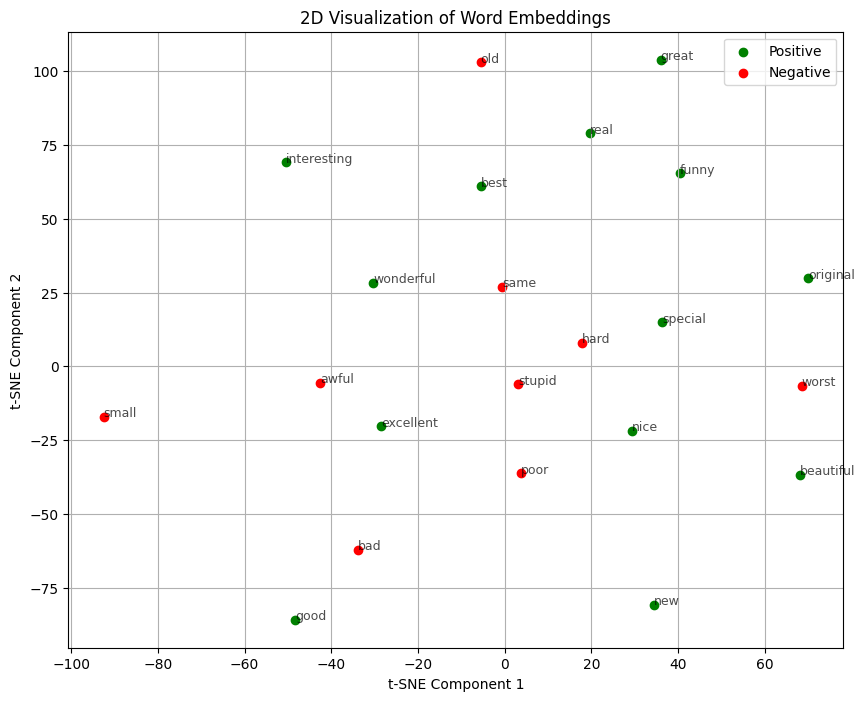

In [ ]:
word_groups = [pos_adjs, neg_adjs]
colors = ['green', 'red']
labels = ['Positive', 'Negative']

evaluator.visualize_embeddings(word_groups, colors, labels)